In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch import optim
from torchvision import utils
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 42
torch.manual_seed(seed=seed)
torch.set_float32_matmul_precision("high")

if device.type == 'cuda':
    torch.cuda.manual_seed_all(seed=seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [14]:
epochs = 100
batch_size = 64
learning_rate = 0.001
latent_dim = 32

In [15]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,)),
])

train_dataset = datasets.CIFAR10(root='/home/pervinco/Datasets/CIFAR10', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='/home/pervinco/Datasets/CIFAR10', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [16]:
class Encoder(nn.Module):
    def __init__(self, latent_dim: int=20):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 4 * 4, latent_dim)
        )

    def forward(self, x):
        x = self.encoder(x)

        return x
    

class Decoder(nn.Module):
    def __init__(self, latent_dim: int=20):
        super().__init__()

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (64, 4, 4)),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # 출력을 [0, 1] 범위로 제한
        )

    def forward(self, x):
        x = self.decoder(x)

        return x
        

class Autoencoder(nn.Module):
    def __init__(self, encoder=Encoder, decoder=Decoder, latent_dim: int=20):
        super().__init__()
        self.encoder = encoder(latent_dim=latent_dim)
        self.decoder = decoder(latent_dim=latent_dim)

        self.latent_dim = latent_dim
    
    def forward(self, x: torch.Tensor):
        z = self.encode(x)
        x_hat = self.decode(z)
        return z, x_hat

    def encode(self, x: torch.Tensor):
        return self.encoder(x)

    def decode(self, z: torch.Tensor):
        return self.decoder(z)

In [17]:
# 저장된 손실 함수를 시각화합니다.
def visualize_loss(epochs, train_loss, valid_loss):
    # x축 계산
    x_len = np.arange(epochs)

    plt.plot(x_len, train_loss, marker=".", c="blue", label="Train Loss")
    plt.plot(x_len, valid_loss, marker=".", c="red", label="Valid Loss")
    # 그래프에 대한 레이블 정보를 우측 상단에 출력합니다.
    plt.legend(loc='upper right')
    plt.grid()
    # x축과 y축에 대한 레이블을 설정합니다.
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

In [18]:
def binary_cross_entropy(x, recon):
    return -torch.sum(x * torch.log(recon) + (1 - x) * torch.log(1 - recon))

In [19]:
autoencoder = Autoencoder(latent_dim=latent_dim).to(device)

recon_loss = nn.MSELoss(reduction='sum')
# recon_loss = binary_cross_entropy
optimizer = optim.Adam(params=list(autoencoder.parameters()), lr=learning_rate)

In [20]:
history = dict(train_loss=[], valid_loss=[])

print(f"Training start with {epochs} epochs.")
for epoch in range(1, 1 + epochs):
    
    train_size = 0
    train_epoch_loss = 0
    autoencoder.train()
    for i, batch in enumerate(train_loader):
        image, label = batch
        image = image.to(device)

        train_size += label.size(0)
        latent = autoencoder.encode(image)
        reconstruction_image = autoencoder.decode(latent)

        # 범위 출력
        # print(f"Epoch {epoch}, Batch {i}")
        # print(f"Input range: [{image.min().item():.4f}, {image.max().item():.4f}]")
        # print(f"Output range: [{reconstruction_image.min().item():.4f}, {reconstruction_image.max().item():.4f}]")

        optimizer.zero_grad()
        train_loss = recon_loss(image, reconstruction_image)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss

    test_size = 0
    test_epoch_loss = 0
    autoencoder.eval()
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            image, label = batch
            image = image.to(device)
            test_size += label.size(0)

            latent = autoencoder.encode(image)
            reconstruction_image = autoencoder.decode(latent)

            test_loss = recon_loss(image, reconstruction_image)
            test_epoch_loss += test_loss

    train_epoch_loss /= train_size
    test_epoch_loss /= test_size

    history["train_loss"].append(train_epoch_loss.item())
    history["valid_loss"].append(test_epoch_loss.item())

    print(f"[{epoch:02d}/{epochs:02d}]"
        + f"Train Loss = {train_epoch_loss:.4f}, "
        + f"Valid Loss = {test_epoch_loss:.4f}")

Training start with 100 epochs.


[01/100]Train Loss = 74.7285, Valid Loss = 46.5546
[02/100]Train Loss = 42.2410, Valid Loss = 40.1880
[03/100]Train Loss = 39.3008, Valid Loss = 40.2301
[04/100]Train Loss = 38.5684, Valid Loss = 40.3083
[05/100]Train Loss = 38.1280, Valid Loss = 38.1970
[06/100]Train Loss = 37.8293, Valid Loss = 38.3516
[07/100]Train Loss = 37.5731, Valid Loss = 38.0042
[08/100]Train Loss = 37.3717, Valid Loss = 37.9332
[09/100]Train Loss = 37.1943, Valid Loss = 38.0273
[10/100]Train Loss = 36.9827, Valid Loss = 36.9638
[11/100]Train Loss = 36.6226, Valid Loss = 36.7899
[12/100]Train Loss = 36.3796, Valid Loss = 37.2584
[13/100]Train Loss = 36.2371, Valid Loss = 36.5946
[14/100]Train Loss = 36.0867, Valid Loss = 36.2925
[15/100]Train Loss = 36.0197, Valid Loss = 36.5668
[16/100]Train Loss = 35.9252, Valid Loss = 36.6856
[17/100]Train Loss = 35.8301, Valid Loss = 36.5134
[18/100]Train Loss = 35.7537, Valid Loss = 36.2411
[19/100]Train Loss = 35.6894, Valid Loss = 36.0995
[20/100]Train Loss = 35.6207, V

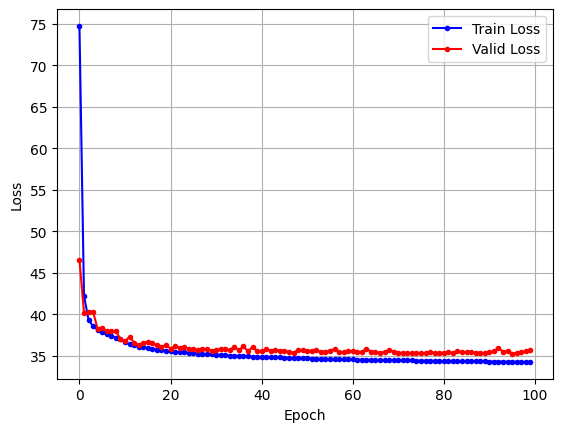

In [21]:
visualize_loss(epochs, history["train_loss"], history["valid_loss"])

데이터 배치 이미지입니다.


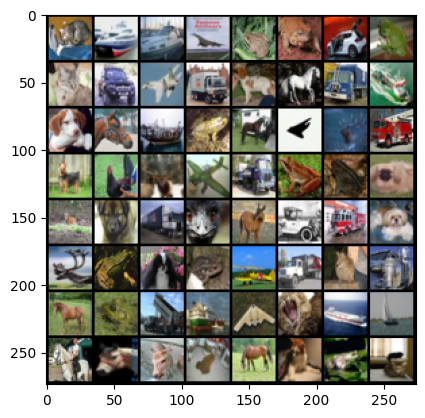

복원된 이미지입니다.


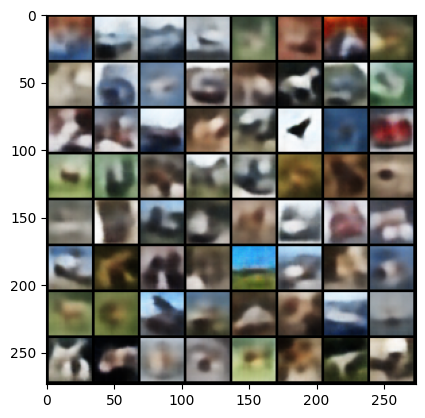

In [22]:
select = 0
autoencoder.eval()
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        if i != select:
            continue
        else:
            test_image, test_label = batch
            test_image = test_image.to(device)
            z = autoencoder.encode(test_image)
            reconstruction = autoencoder.decode(z)
            break

print("데이터 배치 이미지입니다.")
plt.imshow(utils.make_grid(test_image[:64].cpu().view(-1, 3, 32, 32)).permute(1, 2, 0))
plt.show()

print("복원된 이미지입니다.")
plt.imshow(utils.make_grid(reconstruction[:64].cpu().view(-1, 3, 32, 32)).permute(1, 2, 0))
plt.show()